This Notebook creates the PNG surface figures for the sequential KL blueprint

In [1]:
import numpy as np
import nibabel as nib
import scipy.io as sio
from scipy import stats
import pandas as pd
import h5py
import nilearn
import plotly
from nilearn import plotting
import seaborn as sn
from math import pi
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
import mayavi
from mayavi import mlab 
%matplotlib inline


In [2]:
##still getting our data. Matlab to python so we transpose the matrix
pig=h5py.File('./blueprints//L_pig27.mat','r')
variables=pig.items()
for var in variables:
    pig_name=var[0]
    pig_data=var[1]
    print(pig_name)
    print
    pig_data=np.array(pig_data).transpose()
    pig_data=pig_data
hum=h5py.File('./blueprints/L_hum27.mat','r')
variables=hum.items()
for var in variables:
    hum_name=var[0]
    print(hum_name)
    hum_data=var[1]
    hum_data=np.array(hum_data).transpose()



# ##### comment in to run on right hemisphere

# pig=h5py.File('./blueprints//R_pig27.mat','r')
# variables=pig.items()
# for var in variables:
#     pig_name=var[0]
#     pig_data=var[1]
#     print(pig_name)
#     print
#     pig_data=np.array(pig_data).transpose()
#     pig_data=pig_data
# hum=h5py.File('./blueprints//R_hum27.mat','r')
# variables=hum.items()
# for var in variables:
#     hum_name=var[0]
#     print(hum_name)
#     hum_data=var[1]
#     hum_data=np.array(hum_data).transpose()

bp
bp


In [3]:
#### remove extra tracts from human BP
with open('./blueprints//structureList.txt','r') as structs:
    structs=structs.read()
    structs=structs.split('\n')
    ALL_dict={}
for i in range(len(structs)-1):
        ALL_dict[structs[i]]=hum_data[:,i]

In [4]:
def remove_tracts(BP,quitar):
    BP_new=dict(BP)
    orig=BP_new.keys()
    for i in range(len(quitar)):
        val=quitar[i]
        if val in orig:
            del BP_new[val]
    return BP_new

In [5]:
## make pig and human BP's dictionaries
with open('./blueprints//structureList.txt','r') as structs:
    structs=structs.read()
    structs=structs.split('\n')
pig_27={}
hum_27={}
for i in range(len(structs)-1):
    pig_27[structs[i]]=pig_data[:,i]
    hum_27[structs[i]]=hum_data[:,i]
    

In [6]:
##### define KL calculation
### Calculate the KL divergence as done in the Mars blueprint paper
def calc_kl(A,B):
    if type(A) == dict:
        A=list(A.values())
        A=np.array(A).transpose()
    else:
            pass
    if type(B) == dict:
        B=list(B.values())
        B=np.array(B).transpose()
    else:
        pass
    
    p=A.shape
    p=p[0]

    ## function takes two numpy arrays that are the blueprints not normalized
    def normalize(BP,p):
        BP[(np.isnan(BP))]=0
        row_sums=BP.sum(axis=1)
        BP=BP/row_sums[:,np.newaxis]
        return BP
    
    A=normalize(A,p)
    B=normalize(B,p)
    Amask= A!=0
    A_invmask=Amask!=1
    Bmask= B !=0
    B_invmask=Bmask!=1
 
    ##### pyhton implementation of Saad Jaabdi's matlab code fo KL divergence
    KL=np.dot(np.multiply(A,(np.log2((A+A_invmask)))),Bmask.transpose()) \
    - np.dot(A,(Bmask*np.log2(B+B_invmask)).transpose()) \
    + np.dot(Amask,(B*np.log2(B+B_invmask)).transpose())\
    - np.dot(Amask*np.log2(A+A_invmask),B.transpose())
    return KL
    

In [102]:
### save KL images to pngs 
def save_plots(a,b,name):
    plt.subplot(1,2,1)
    plt.imshow(b)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(a)
    plt.axis('off')
    plt.subplots_adjust(hspace = -0.2)
    plt.savefig(f'/Volumes/Macintosh_HD/Users/Austin/Desktop/L_KL_Tings_Idea/{name}.png',bbox_inches='tight',dpi=800,facecolor='w')
    plt.clf()



#### comment in for right hemisphere 
# def save_plots(a,b,name):
#     plt.subplot(2,2,1)
#     plt.imshow(a)
#     plt.axis('off')
#     plt.subplot(1,2,2)
#     plt.imshow(b)
#     plt.axis('off')
#     plt.subplots_adjust(hspace = -0.2)
    
#     plt.savefig(f'/Volumes/Macintosh_HD/Users/Austin/Desktop/L_KL_Tings_Idea/{name}.png',bbox_inches='tight',dpi=800)
#     plt.clf()

# save_plots(p_all1,p_all2,'R_passoc')

In [114]:
import matplotlib

In [117]:
#### function defining the plotting of the K vectors over the surfaces
def oh_mayavi(surf,stat,cmap,vmi,vma,*args):
    ##### parse the gifti 
    anat=nib.load(surf)
    coords=anat.darrays[0].data
    x=coords[:,0]
    y=coords[:,1]
    z=coords[:,2]
    triangles=anat.darrays[1].data
    ##### if subcortical mask provided use it
    if len(args) >0:
        print('masking out subcortex')
        sub_cort=nilearn.surface.load_surf_data(args[0])
        stat[sub_cort]=float('NaN')
    else:
        pass
    
    
    ### start mayavi 
    mlab.init_notebook('png',1500,1500)
    maya=mlab.triangular_mesh(x,y,z,triangles,scalars=stat,colormap=cmap,vmin=vmi,vmax=vma)
    
    mlab.view(azimuth=0, elevation=-90)
    f = mlab.gcf()
    cam = f.scene.camera
    cam.zoom(1.)
#     cb=mlab.colorbar(orientation='vertical', nb_labels=3,label_fmt='%.2f')
#     cb.label_text_property.color =(0,0,0)
    

    mlab.draw()
    

    img1=mlab.screenshot(figure=maya,mode='rgba',antialiased=True)
    mlab.view(azimuth=0, elevation=90)
    mlab.figure(bgcolor=(0, 0, 0))
    ### clear figure
    mayavi.mlab.clf()
    
    f = mlab.gcf()
    cam = f.scene.camera
    cam.zoom(1.1)
    mlab.draw()
    img2=mlab.screenshot(figure=maya,mode='rgba',antialiased=True)
    ### clear figure
    mayavi.mlab.clf()
    return img1,img2

In [28]:
##### pig = min on axis 1
#### hum = min on axis = 0 
hum_27.keys()

dict_keys(['atr_l', 'atr_r', 'cbd_l', 'cbd_r', 'cbt_l', 'cbt_r', 'cbp_l', 'cbp_r', 'cst_l', 'cst_r', 'fma', 'fmi', 'fx_l', 'fx_r', 'ifo_l', 'ifo_r', 'ilf_l', 'ilf_r', 'mcp', 'or_l', 'or_r', 'ptr_l', 'ptr_r', 'str_l', 'str_r', 'unc_l', 'unc_r'])

In [29]:
#### calculate KL and get min for only projection tracts
hum_proj=remove_tracts(hum_27,['atr_l','atr_r', 'cst_l', 'cst_r','or_l', 'or_r', 'ptr_l', 'ptr_r', 'str_l', 'str_r'])
pig_proj=remove_tracts(pig_27,['atr_l','atr_r', 'cst_l', 'cst_r','or_l', 'or_r', 'ptr_l', 'ptr_r', 'str_l', 'str_r'])
KL_proj=calc_kl(pig_proj,hum_proj)
p_proj=KL_proj.min(axis=1)
h_proj=KL_proj.min(axis=0)
print(np.max(p_proj))
print(np.max(h_proj))

4.116178513059977
5.144464803038697


In [30]:
hum_comm=remove_tracts(hum_27,[ 'fma', 'fmi','mcp'])
pig_comm=remove_tracts(pig_27,['fma', 'fmi','mcp' ])
KL_comm=calc_kl(pig_comm,hum_comm)
p_comm=KL_comm.min(axis=1)
h_comm=KL_comm.min(axis=0)
print(np.max(p_comm))
print(np.max(h_comm))

4.0584062757503965
5.507333263883929


In [31]:
hum_assoc=remove_tracts(hum_27,['ifo_l', 'ifo_r', 'ilf_l', 'ilf_r','unc_l', 'unc_r' ])
pig_assoc=remove_tracts(pig_27,['ifo_l', 'ifo_r', 'ilf_l', 'ilf_r','unc_l', 'unc_r' ])
KL_assoc=calc_kl(pig_assoc,hum_assoc)
p_assoc=KL_assoc.min(axis=1)
h_assoc=KL_assoc.min(axis=0)
print(np.max(p_assoc))
print(np.max(h_assoc))

3.2762650991961664
5.969086411180758


In [32]:
hum_limbic=remove_tracts(hum_27,['cbd_l', 'cbd_r', 'cbt_l', 'cbt_r', 'cbp_l','fx_l', 'fx_r' ])
pig_limbic=remove_tracts(pig_27,['cbd_l', 'cbd_r', 'cbt_l', 'cbt_r', 'cbp_l','fx_l', 'fx_r' ])
KL_limbic=calc_kl(pig_limbic,hum_limbic)
p_limbic=KL_limbic.min(axis=1)
h_limbic=KL_limbic.min(axis=0)
print(np.max(p_limbic))
print(np.max(h_limbic))

2.883716712151551
4.101402451534117


In [33]:
#### calc KL including all 
KL=calc_kl(pig_27,hum_27)
h_all=KL.min(axis=0)
p_all=KL.min(axis=1)
# KL=np.divide()
hmax=KL.min(axis=0).max()
pmax=KL.min(axis=1).max()
print(np.max(p_all))
print(np.max(h_all))

4.139713526511919
5.722649518067529


In [34]:
import scipy


In [35]:
# plt.plot(h_proj, h_all, '.')
# plt.plot(h_proj, 0.26151855073978475 + 0.9359792319299068 * h_proj, '-')


In [36]:
r=0.77


In [37]:
scipy.stats.linregress(h_all,h_proj)

LinregressResult(slope=0.6482235962801781, intercept=0.013025757475370325, rvalue=0.778924786975715, pvalue=0.0, stderr=0.005219150818123753)

In [86]:
def plot_r_bps(A,B,out):
    A = A[~np.isnan(A)]
    B = B[~np.isnan(B)]
    m,b,r,p,st=scipy.stats.linregress(A,B)
    plt.figure(figsize=(4,2))
    ax=sn.regplot(A,B,scatter_kws={'s':3,'alpha':0.5,'color':'lightsteelblue'},
                  line_kws={'color':'mediumseagreen'})
    ax.text(0.05, 0.9,f'r={r:.2f}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
    plt.savefig(f'/Volumes/Macintosh_HD/Users/Austin/Desktop/L_KL_Tings_Idea/{out}.pdf',bbox_inches='tight',dpi=800,facecolor='w')
    return m,b,r

(0.5381382642487769, 0.1027305848841843, 0.737548455234271)

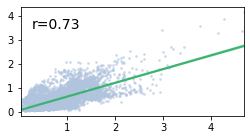

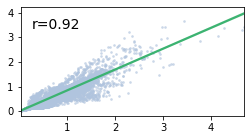

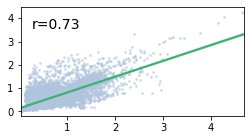

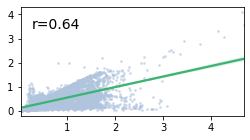

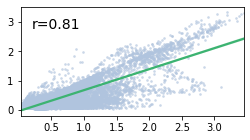

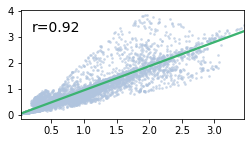

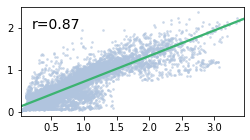

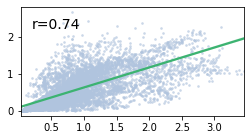

In [87]:
plot_r_bps(h_all,h_proj,'h_proj+h_all')
plot_r_bps(h_all,h_comm,'h_comm+h_all')
plot_r_bps(h_all,h_assoc,'h_assoc+h_all')
plot_r_bps(h_all,h_limbic,'h_limbic+h_all')

plot_r_bps(p_all,p_proj,'p_proj+p_all')
plot_r_bps(p_all,p_comm,'p_comm+p_all')
plot_r_bps(p_all,p_assoc,'p_assoc+p_all')
plot_r_bps(p_all,p_limbic,'p_limbic+p_all')

In [93]:
# ### plot the lateral and axial views of the surfaces in mayavi 
# #### plotting human

##### note that it is best to run each set of tracts one by one commenting in and out for right now. 

h_proj2,h_proj1=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_proj,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')
h_comm2,h_comm1=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_comm,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')
h_assoc2,h_assoc1=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_assoc,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')
h_limbic2,h_limbic1=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_limbic,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')
h_all2,h_all1=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_all,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')

# ###### plotting pig
p_proj2,p_proj1=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii',p_proj,'terrain',0,pmax,'./surfaces/labels/L.pig.subcort.label')
p_comm2,p_comm1=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii',p_comm,'terrain',0,pmax,'./surfaces/labels/L.pig.subcort.label')
p_assoc2,p_assoc1=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii',p_assoc,'terrain',0,pmax,'./surfaces/labels/L.pig.subcort.label')
p_limbic2,p_limbic1=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii',p_limbic,'terrain',0,pmax,'./surfaces/labels/L.pig.subcort.label')
p_all2,p_all1=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii',p_all,'terrain',0,pmax,'./surfaces/labels/L.pig.subcort.label')

# ## commnet in to run on right 

##### plot the lateral and axial views of the surfaces in mayavi 
##### plotting human
# h_proj1,h_proj2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/R.rhum.inflated.surf.gii',h_proj,'terrain',0,hmax,'./surfaces/labels/R.hum.subcort.label')
# h_comm1,h_comm2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/R.rhum.inflated.surf.gii',h_comm,'terrain',0,hmax,'./surfaces/labels/R.hum.subcort.label')
# h_assoc1,h_assoc2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/R.rhum.inflated.surf.gii',h_assoc,'terrain',0,hmax,'./surfaces/labels/R.hum.subcort.label')
# h_all1,h_all2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/R.rhum.inflated.surf.gii',h_all,'terrain',0,hmax,'./surfaces/labels/R.hum.subcort.label')
# ###### plotting pig
# p_proj1,p_proj2=oh_mayavi('./surfaces/pig_surfaces/rh.inflated10k.surf.gii',p_proj,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')
# p_comm1,p_comm2=oh_mayavi('./surfaces/pig_surfaces/rh.inflated10k.surf.gii',p_comm,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')
# p_assoc1,p_assoc2=oh_mayavi('./surfaces/pig_surfaces/rh.inflated10k.surf.gii',p_assoc,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')
# p_assoc1,p_assoc2=oh_mayavi('./surfaces/pig_surfaces/rh.inflated10k.surf.gii',p_limbic,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')
# p_all1,p_all2=oh_mayavi('./surfaces/pig_surfaces/rh.inflated10k.surf.gii',p_all,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')

masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.


In [94]:
print(f'projection tract max is {np.nanmax(difHallHproj)}')
print(f'comm tract max is {np.nanmax(difHallHcomm)}')
print(f'asociaiton tract max is {np.nanmax(difHallHassoc)}')
print(f'limbic tract max is {np.nanmax(difHallHlimbic)}')
Hmax_dif=np.nanmax(difHallHlimbic)

projection tract max is 2.099982585545
comm tract max is 1.5015615740710362
asociaiton tract max is 2.044104795945568
limbic tract max is 2.8866237032769813


In [95]:
print(f'projection tract max is {np.nanmax(difPallPproj)}')
print(f'comm tract max is {np.nanmax(difPallPcomm)}')
print(f'asociaiton tract max is {np.nanmax(difPallPassoc)}')
print(f'limbic tract max is {np.nanmax(difPallPlimbic)}')
Pmax_dif=np.nanmax(difPallPlimbic)

projection tract max is 2.309574260843713
comm tract max is 1.4323245401471203
asociaiton tract max is 2.0055686294754027
limbic tract max is 2.4044552014455594


In [121]:
difPallPproj=p_all - p_proj
p_dif1,p_dif2=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii'\
                        ,difPallPproj,'CMRmap',0,Pmax_dif,\
                        './surfaces/labels/L.pig.subcort.label')
save_plots(p_dif2,p_dif1,'L_p_diff_proj')

difHallHproj=h_all - h_proj
h_dif1,h_dif2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',\
                           difHallHproj,'CMRmap',0,Hmax_dif,'./surfaces/labels/L.hum.subcort.label')
save_plots(h_dif2,h_dif1,'L_h_diff_proj')



masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.


<Figure size 432x288 with 0 Axes>

In [120]:
difPallPcomm=p_all - p_comm
p_dif1,p_dif2=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii'\
                        ,difPallPcomm,'CMRmap',0,Pmax_dif,\
                        './surfaces/labels/L.pig.subcort.label')
save_plots(p_dif2,p_dif1,'L_p_diff_comm')

difHallHcomm=h_all - h_comm
h_dif1,h_dif2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',\
                           difHallHcomm,'CMRmap',0,Hmax_dif,'./surfaces/labels/L.hum.subcort.label')
save_plots(h_dif2,h_dif1,'L_h_diff_comm')




masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.


<Figure size 432x288 with 0 Axes>

In [122]:
difPallPassoc=p_all - p_assoc
p_dif1,p_dif2=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii'\
                        ,difPallPassoc,'CMRmap',0,Pmax_dif,\
                        './surfaces/labels/L.pig.subcort.label')
save_plots(p_dif2,p_dif1,'L_p_diff_assoc')

difHallHassoc=h_all - h_assoc
h_dif1,h_dif2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',\
                           difHallHassoc,'CMRmap',0,Hmax_dif,'./surfaces/labels/L.hum.subcort.label')
save_plots(h_dif2,h_dif1,'L_h_diff_assoc')





masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.


<Figure size 432x288 with 0 Axes>

In [123]:
difPallPlimbic=p_all - p_limbic
p_dif1,p_dif2=oh_mayavi('./surfaces/pig_surfaces/lh.inflated10k.surf.gii'\
                        ,difPallPlimbic,'CMRmap',0,Pmax_dif,\
                        './surfaces/labels/L.pig.subcort.label')
save_plots(p_dif2,p_dif1,'L_p_diff_limbic')

difHallHlimbic=h_all - h_limbic
h_dif1,h_dif2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',\
                           difHallHlimbic,'CMRmap',0,Hmax_dif,'./surfaces/labels/L.hum.subcort.label')
save_plots(h_dif2,h_dif1,'L_h_diff_limbic')





masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.


<Figure size 432x288 with 0 Axes>

In [100]:

save_plots(p_proj1,p_proj2,'L_p_proj')
save_plots(p_comm1,p_comm2,'L_pcomm')
save_plots(p_assoc1,p_assoc2,'L_passoc')
save_plots(p_limbic1,p_limbic2,'L_plimbic')
save_plots(p_all1,p_all2,'L_pall')

save_plots(h_proj1,h_proj2,'L_h_proj')
save_plots(h_comm1,h_comm2,'L_hcomm')
save_plots(h_assoc1,h_assoc2,'L_hassoc')
save_plots(h_limbic1,h_limbic2,'L_hlimbic')
save_plots(h_all1,h_all2,'L_hall')


###### comment in for right hemisphere (run one by one)
# save_plots(p_proj2,p_proj1,'R_p_proj')
# save_plots(p_comm2,p_comm1,'R_pcomm')
# save_plots(p_assoc2,p_assoc1,'R_passoc')
# save_plots(p_limbic1,p_limbic2,'R_plimbic')
# save_plots(p_all2,p_all1,'R_pall')

# save_plots(h_proj2,h_proj1,'R_h_proj')
# save_plots(h_comm2,h_comm1,'R_hcomm')
# save_plots(h_assoc2,h_assoc1,'R_hassoc')
# save_plots(h_limbic1,h_limbic2,'R_hlimbic')
# save_plots(h_all2,h_all1,'R_hall')




<Figure size 432x288 with 0 Axes>

In [124]:
nanmax

4.139713526511919

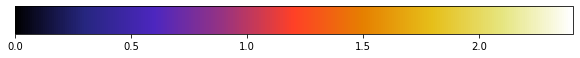

In [126]:
fig, ax = plt.subplots(figsize=(10,1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.CMRmap
norm = mpl.colors.Normalize(vmin=0, vmax=Pmax_dif)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
# cb1.outline.set_edgecolor('k')
ax.tick_params(axis='y', colors='white')


# ax.remove()
# cb1.set_label('Human KL Divergence')
plt.plot()
plt.savefig('/Volumes/Macintosh_HD/Users/Austin/Desktop/L_KL_Tings_Idea/L_pigDif_colorbar.png',
            bbox_inches='tight',facecolor='w',edgecolor='w')

In [ ]:
R_hmax=7.687934938285256

In [ ]:
L_hmax=5.722649518067529

In [ ]:
R_hmax=8.00090351247032